In [1]:
import xarray as xr
import fsspec
import numpy as np
import s3fs
import zarr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Loading years: 100%|██████████| 46/46 [00:47<00:00,  1.02s/it]


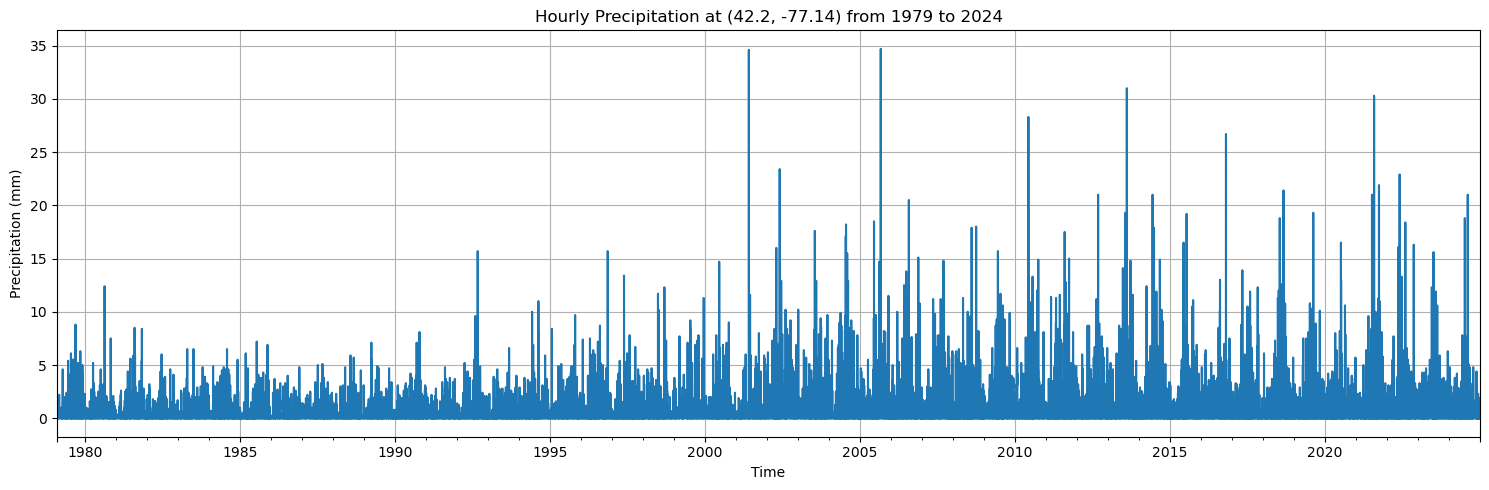

In [2]:
base_url = 's3://noaa-nws-aorc-v1-1-1km'
years = range(1979, 2025)

# NYS location (Albany)
lat_nys = 42.2
lon_nys = -77.14
var = 'APCP_surface'

# Store all years here
all_ts = []

for year in tqdm(years, desc="Loading years"):  
    single_year_url = f"{base_url}/{year}.zarr/"
    
    # Load dataset for one year
    ds = xr.open_zarr(
        single_year_url,
        consolidated=True,
        storage_options={"anon": True}
    )
    
    # Extract time series at nearest lat/lon
    precip_ts = ds[var].sel(
        latitude=lat_nys, longitude=lon_nys, method='nearest'
    )
    
    # Convert to pandas Series and append
    ts_df = precip_ts.to_series()
    all_ts.append(ts_df)

# Concatenate all years into one Series
hourly_series = pd.concat(all_ts)

# Plot full time series
plt.figure(figsize=(15, 5))
hourly_series.plot()
plt.title(f"Hourly Precipitation at ({lat_nys}, {lon_nys}) from 1979 to 2024")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

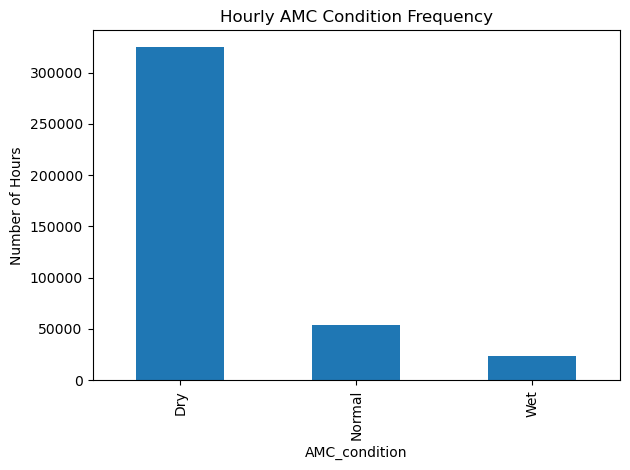

In [8]:
# Combine into a full hourly time series
hourly_series = pd.concat(all_ts)

# Compute rolling 5-day rainfall (120-hour window)
antecedent_5day = hourly_series.rolling(window=120).sum()

# Classification function using hourly timestamps
def classify_amc_hourly(timestamp, total_5d_mm):
    month = timestamp.month
    if pd.isna(total_5d_mm):
        return None
    if 5 <= month <= 10:
        if total_5d_mm < 35.6:
            return 'Dry'
        elif total_5d_mm <= 53.4:
            return 'Normal'
        else:
            return 'Wet'
    else:
        if total_5d_mm < 12.7:
            return 'Dry'
        elif total_5d_mm <= 28:
            return 'Normal'
        else:
            return 'Wet'

# Apply classification to every hourly timestamp
amc_class = pd.Series(
    [classify_amc_hourly(ts, rain) for ts, rain in antecedent_5day.items()],
    index=antecedent_5day.index
)

# Combine into DataFrame
df_hourly_amc = pd.DataFrame({
    'hourly_rain_mm': hourly_series,
    'antecedent_5day_mm': antecedent_5day,
    'AMC_condition': amc_class
})

# Preview
#print(df_hourly_amc.head(24))

# Optional: plot AMC condition frequency
df_hourly_amc['AMC_condition'].value_counts().plot(kind='bar', title='Hourly AMC Condition Frequency')
plt.ylabel("Number of Hours")
plt.tight_layout()
plt.show()

C:\Users\Omid Emamjomehzadeh\AppData\Local\Temp\ipykernel_65820\2533392319.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max = hourly_series.resample('Y').max()


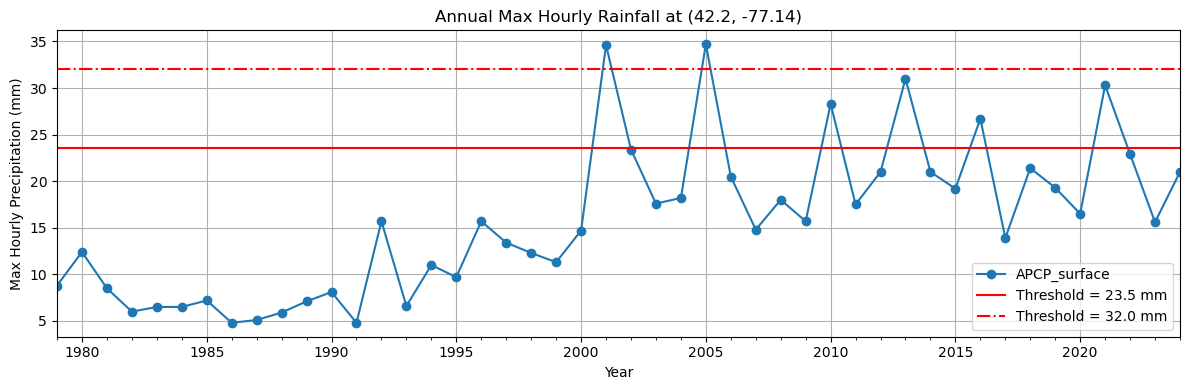

In [5]:
# Resample to annual max
annual_max = hourly_series.resample('Y').max()

# Calculate threshold in mm
thresh_1 = 0.927 * 25.4 
thresh_2 = 1.26 * 25.4  

# Plot
plt.figure(figsize=(12, 4))
annual_max.plot(marker='o')
plt.axhline(thresh_1, color='red', linestyle='-', label=f'Threshold = {thresh_1:.1f} mm')
plt.axhline(thresh_2, color='red', linestyle='-.', label=f'Threshold = {thresh_2:.1f} mm')

plt.title(f"Annual Max Hourly Rainfall at ({lat_nys}, {lon_nys})")
plt.ylabel("Max Hourly Precipitation (mm)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

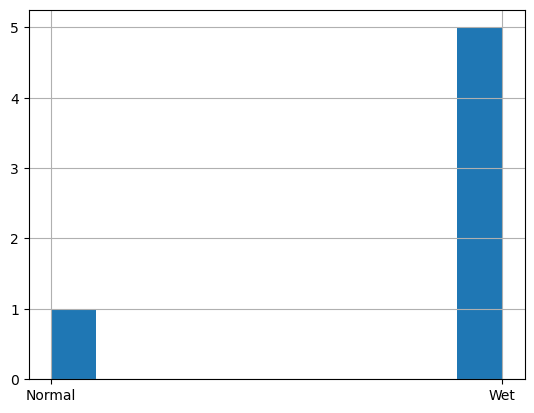

In [6]:
thresh=0.927*25.4
df_hourly_amc[hourly_series>thresh]['AMC_condition'].hist()

<Axes: >

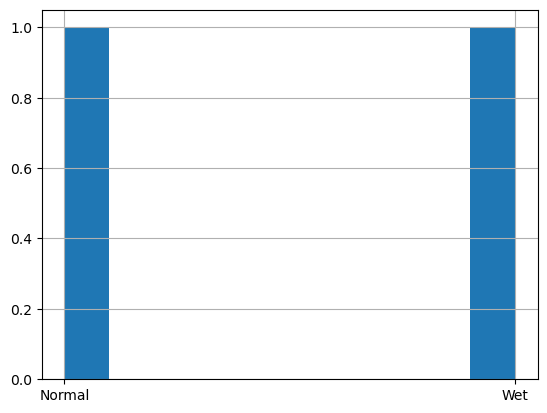

In [7]:
df_hourly_amc[hourly_series>thresh_2]['AMC_condition'].hist()

# new coordinates

Loading years: 100%|██████████| 46/46 [00:39<00:00,  1.16it/s]


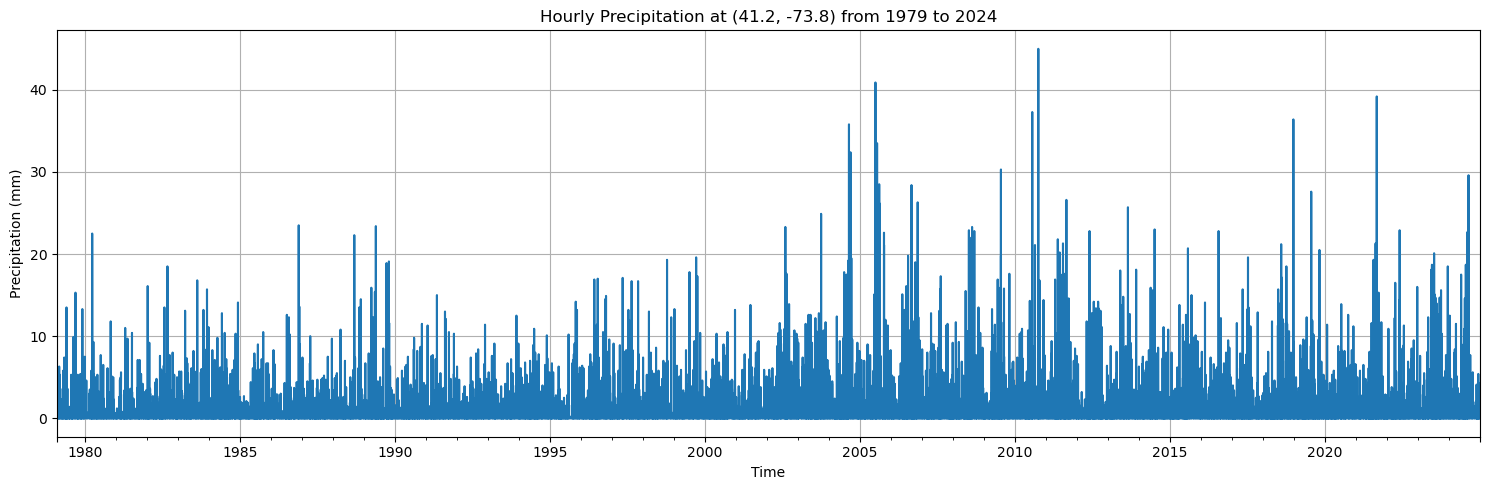

In [9]:
base_url = 's3://noaa-nws-aorc-v1-1-1km'
years = range(1979, 2025)

# 41.2, -73.8
lat_nys = 41.2
lon_nys = -73.8
var = 'APCP_surface'

# Store all years here
all_ts = []

for year in tqdm(years, desc="Loading years"):  
    single_year_url = f"{base_url}/{year}.zarr/"
    
    # Load dataset for one year
    ds = xr.open_zarr(
        single_year_url,
        consolidated=True,
        storage_options={"anon": True}
    )
    
    # Extract time series at nearest lat/lon
    precip_ts = ds[var].sel(
        latitude=lat_nys, longitude=lon_nys, method='nearest'
    )
    
    # Convert to pandas Series and append
    ts_df = precip_ts.to_series()
    all_ts.append(ts_df)

# Concatenate all years into one Series
hourly_series = pd.concat(all_ts)

# Plot full time series
plt.figure(figsize=(15, 5))
hourly_series.plot()
plt.title(f"Hourly Precipitation at ({lat_nys}, {lon_nys}) from 1979 to 2024")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

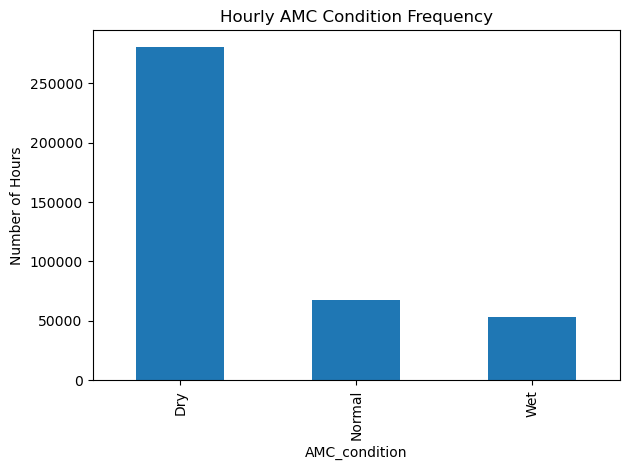

In [31]:
# Combine into a full hourly time series
hourly_series = pd.concat(all_ts)

# Compute rolling 5-day rainfall (120-hour window)
antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

# Classification function using hourly timestamps
def classify_amc_hourly(timestamp, total_5d_mm):
    month = timestamp.month
    if pd.isna(total_5d_mm):
        return None
    if 5 <= month <= 10:
        if total_5d_mm < 35.6:
            return 'Dry'
        elif total_5d_mm <= 53.4:
            return 'Normal'
        else:
            return 'Wet'
    else:
        if total_5d_mm < 12.7:
            return 'Dry'
        elif total_5d_mm <= 28:
            return 'Normal'
        else:
            return 'Wet'

# Apply classification to every hourly timestamp
amc_class = pd.Series(
    [classify_amc_hourly(ts, rain) for ts, rain in antecedent_5day.items()],
    index=antecedent_5day.index
)

# Combine into DataFrame
df_hourly_amc = pd.DataFrame({
    'hourly_rain_mm': hourly_series,
    'antecedent_5day_mm': antecedent_5day,
    'AMC_condition': amc_class
})

# Preview
#print(df_hourly_amc.head(24))

# Optional: plot AMC condition frequency
df_hourly_amc['AMC_condition'].value_counts().plot(kind='bar', title='Hourly AMC Condition Frequency')
plt.ylabel("Number of Hours")
plt.tight_layout()
plt.show()

C:\Users\Omid Emamjomehzadeh\AppData\Local\Temp\ipykernel_65820\1766713353.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max = hourly_series.resample('Y').max()


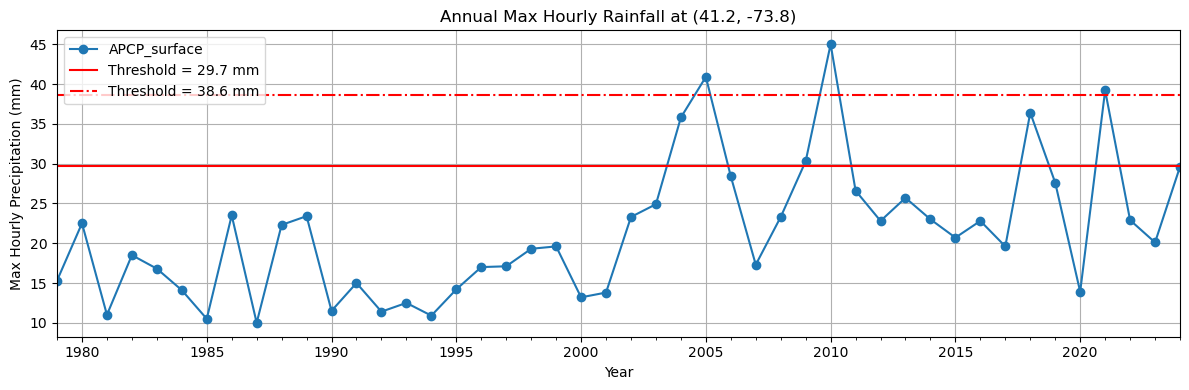

In [ ]:
# Resample to annual max
annual_max = hourly_series.resample('YE').max()

# Calculate threshold in mm
thresh_1 = 1.17 * 25.4 
thresh_2 = 1.52 * 25.4  

# Plot
plt.figure(figsize=(12, 4))
annual_max.plot(marker='o')
plt.axhline(thresh_1, color='red', linestyle='-', label=f'Threshold = {thresh_1:.1f} mm')
plt.axhline(thresh_2, color='red', linestyle='-.', label=f'Threshold = {thresh_2:.1f} mm')

plt.title(f"Annual Max Hourly Rainfall at ({lat_nys}, {lon_nys})")
plt.ylabel("Max Hourly Precipitation (mm)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

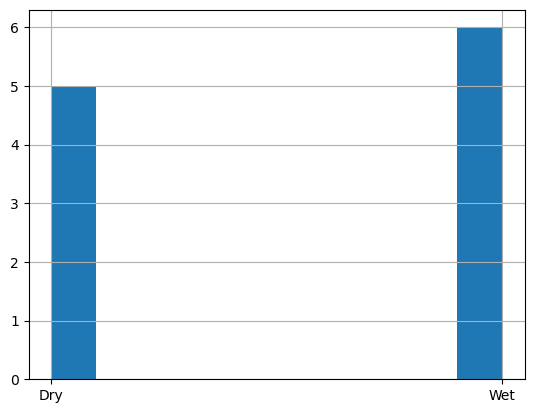

In [33]:
df_hourly_amc[hourly_series>thresh_1]['AMC_condition'].hist()

<Axes: >

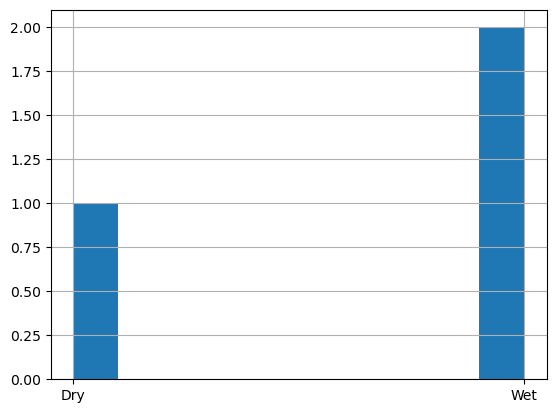

In [34]:
df_hourly_amc[hourly_series>thresh_2]['AMC_condition'].hist()

In [76]:
def analyze_aorc_amc_plots(lat, lon, thresholds_in, start_year=1979, end_year=2024):
    base_url = 's3://noaa-nws-aorc-v1-1-1km'
    var = 'APCP_surface'
    thresholds_mm = [t * 25.4 for t in thresholds_in]  # Convert to mm
    years = range(start_year, end_year + 1)

    all_ts = []
    for year in tqdm(years, desc="Loading years"):
        url = f"{base_url}/{year}.zarr/"
        ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})
        precip_ts = ds[var].sel(latitude=lat, longitude=lon, method='nearest')
        all_ts.append(precip_ts.to_series())

    hourly_series = pd.concat(all_ts)

    # === Plot 1: Full Hourly Time Series ===
    plt.figure(figsize=(8, 3))
    hourly_series.plot()
    plt.title(f"Hourly Precipitation at ({lat}, {lon})")
    plt.ylabel("Precipitation (mm)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Compute 5-day total ===
    antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

    def classify_amc(ts, rain_5d):
        m = ts.month
        if pd.isna(rain_5d):
            return None
        if 5 <= m <= 10:
            if rain_5d < 35.6: return 'Dry'
            elif rain_5d <= 53.4: return 'Normal'
            else: return 'Wet'
        else:
            if rain_5d < 12.7: return 'Dry'
            elif rain_5d <= 28: return 'Normal'
            else: return 'Wet'

    amc = pd.Series(
        [classify_amc(ts, rain) for ts, rain in antecedent_5day.items()],
        index=antecedent_5day.index
    )

    df = pd.DataFrame({
        'hourly_rain_mm': hourly_series,
        'antecedent_5day_mm': antecedent_5day,
        'AMC': amc
    })

    
    # === Merged AMC Distributions on Same Axis ===
    plt.figure(figsize=(8, 4.5))
    bar_width = 0.2
    amc_order = ['Dry', 'Normal', 'Wet']

    # --- 1. Plot AMC at Annual Maxima ---
    annual_max_idx = hourly_series.resample('YE').apply(lambda x: x.idxmax()).dropna()
    amc_annual_max = df.loc[annual_max_idx, 'AMC']
    counts_annual = amc_annual_max.value_counts(normalize=True).reindex(amc_order).fillna(0)

    plt.bar(
        [x for x in range(len(amc_order))],
        counts_annual.values,
        width=bar_width,
        label='Annual maxima events',
        edgecolor='black',
        color='mediumseagreen'
    )

    # --- 2. Plot AMC for each threshold ---
    for i, (t_mm, t_in) in enumerate(zip(thresholds_mm, thresholds_in)):
        subset = df[df['hourly_rain_mm'] > t_mm]
        counts = subset['AMC'].value_counts(normalize=True).reindex(amc_order).fillna(0)

        # Offset bar position to avoid overlap
        offset = (i + 1) * bar_width
        plt.bar(
            [x + offset for x in range(len(amc_order))],
            counts.values,
            width=bar_width,
            label=f'>{t_in:.2f}"',
            edgecolor='black'
        )

    # --- Formatting ---
    total_bars = len(thresholds_in) + 1
    midpoints = [x + bar_width * (total_bars - 1) / 2 for x in range(len(amc_order))]
    plt.xticks(midpoints, amc_order, fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.title("AMC Probabilities (Annual Maxima & Threshold Events)", fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(title="Condition", fontsize=10)
    plt.tight_layout()
    plt.show()

    

Loading years: 100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


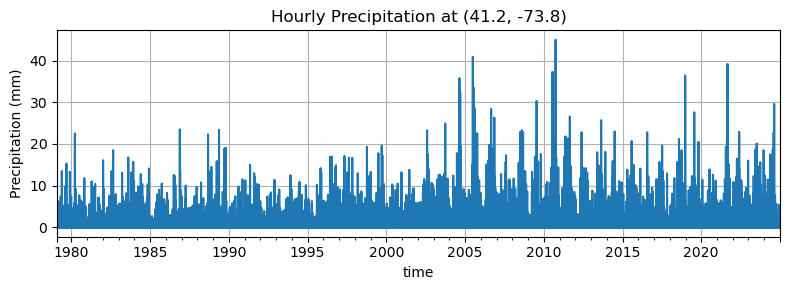

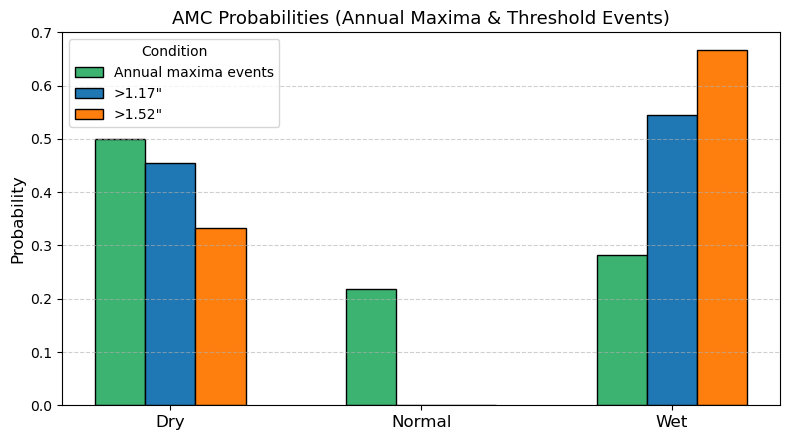

In [77]:
thresholds = [1.17, 1.52]  # in inches
lat_nys = 41.2
lon_nys = -73.8

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s]


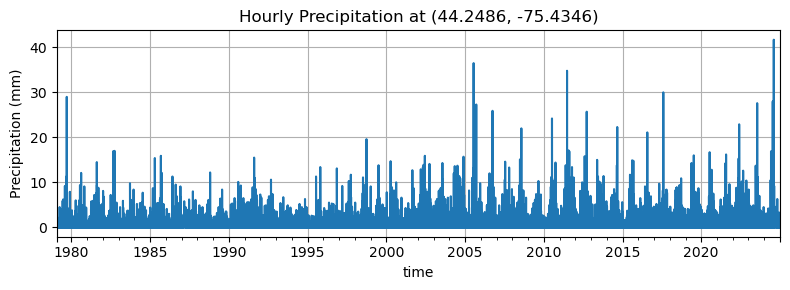

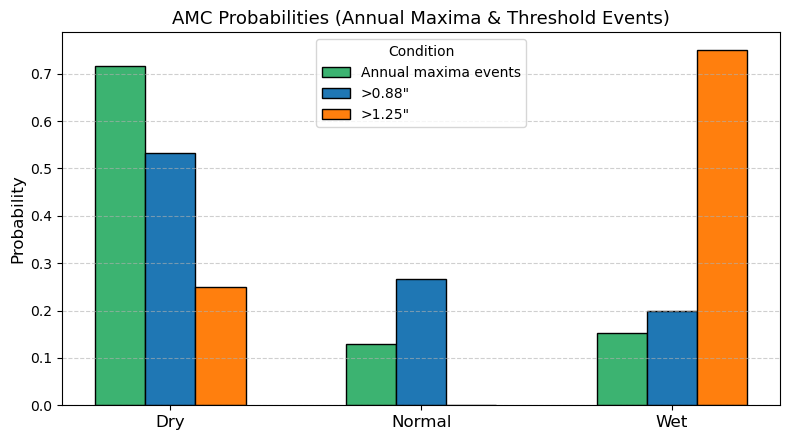

In [78]:
thresholds = [0.878, 1.25]  # in inches
lat_nys = 44.2486
lon_nys = -75.4346

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


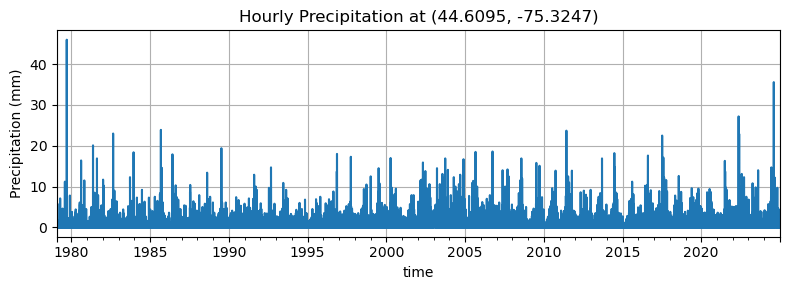

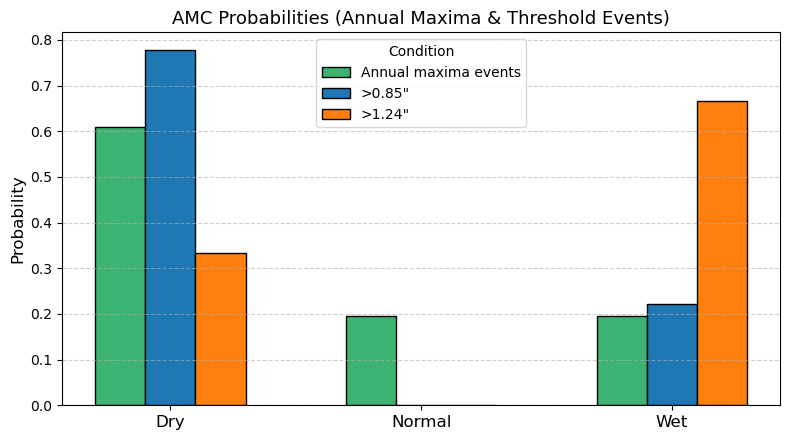

In [79]:
thresholds = [0.850, 1.24]  # in inches
lat_nys =  44.6095
lon_nys = -75.3247

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


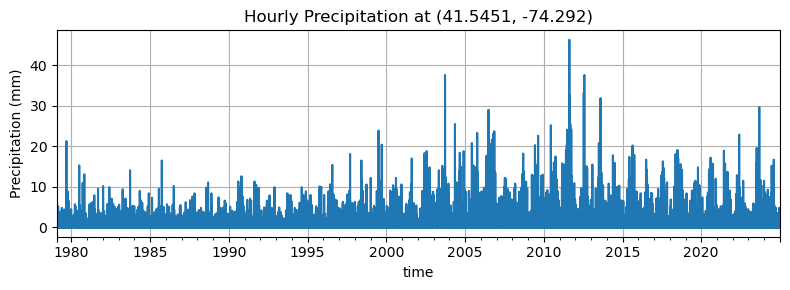

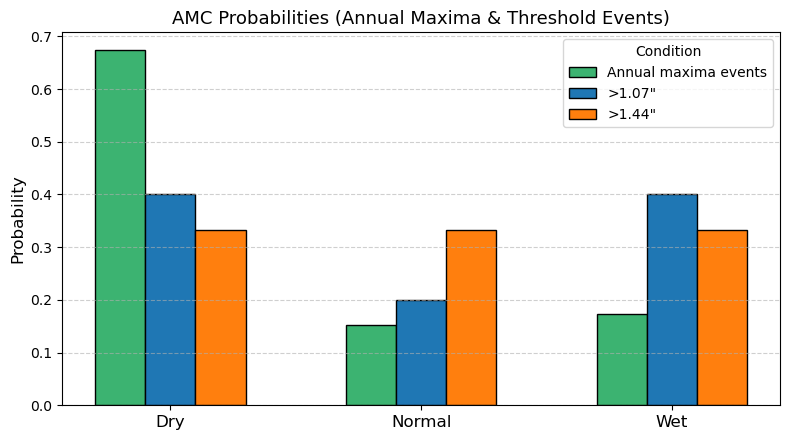

In [80]:
thresholds = [1.07, 1.44]  # in inches
lat_nys =  41.5451
lon_nys = -74.2920

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:39<00:00,  1.15it/s]


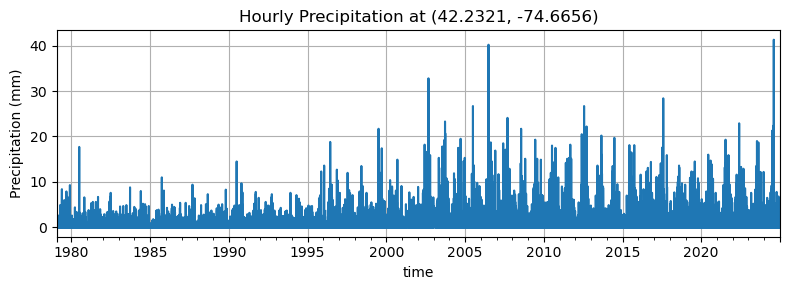

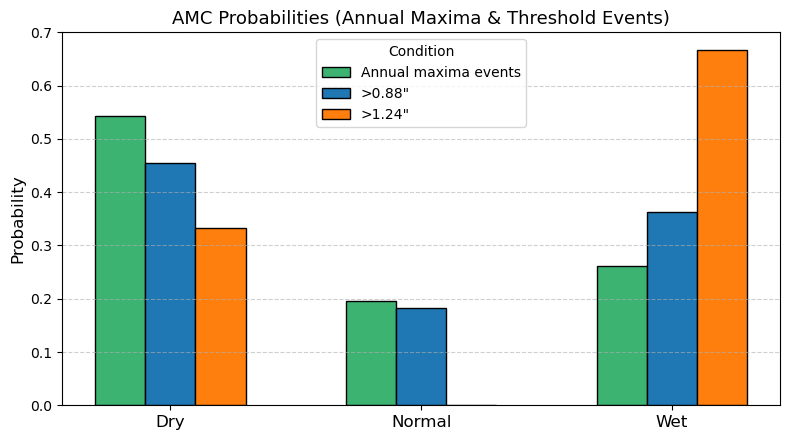

In [81]:
thresholds = [0.880, 1.24]  # in inches
lat_nys =  42.2321
lon_nys = -74.6656

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)